In [2]:
import pandas as pd
import os
import numpy as np
#!pip install python-docx 
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [3]:
os.chdir('/content/drive/MyDrive/Python/EU UK deal')

In [4]:
os.listdir()

['EU UK deal.ipynb',
 'EU-UK_Trade_and_Cooperation_Agreement_24.12.2020.pdf',
 'EUUK.txt',
 'EU-UK_Trade_and_Cooperation_Agreement_24.12.2020.gdoc',
 'EU-UK.docx',
 'Data',
 'app.py']

In [4]:
from docx import Document

document = Document('EU-UK.docx')


In [5]:
#clean up:
paragraphs = [para for para in document.paragraphs if len(para.text) >0]
paragraphs = [para for para in paragraphs if not para.text.isspace()]
len(paragraphs)

14249

In [6]:
text = []
for i in paragraphs:
  text.append(i.text)

#annexes start at 5824

text = text[0:5824]

# text = " ".join(text)

# len(text)

In [156]:
titles = [txt if txt.startswith('TITLE') else None for txt in text]
parts = [txt if txt.startswith('PART') else None for txt in text]
articles = [txt if txt.startswith('Article ') else None for txt in text]

In [157]:
d = {'Titles':titles,'Parts':parts, 'Articles':articles,'Text':text}
df = pd.DataFrame(d)

cols = ['Titles', 'Parts', 'Articles']
df.loc[:,cols] = df.loc[:,cols].ffill()

df.dropna(inplace=True)
df.reset_index(inplace=True)

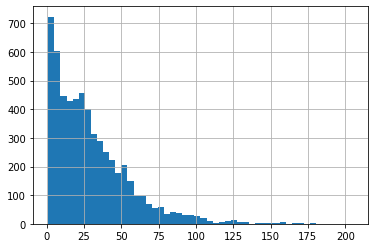

In [158]:
df['Words'] = df['Text'].str.split().str.len()
df['Words'].hist(bins=50)

df['article_check'] = np.where(df.Text==df.Articles,1,0)
df = df.loc[df.article_check !=1]
df = df.drop(columns=['article_check'])
df.reset_index(inplace=True)

5024


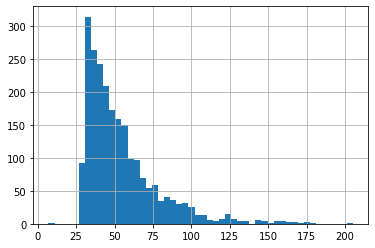

In [159]:
df['remove'] = 0
for article in df.Articles.value_counts().index:
  #go article by article to prevent text getting stuck to different articles...
  df_article = df.loc[df.Articles == article]
  for i in df_article.loc[(df_article.Words<30)].index:
    try:
      previous = df.iloc[i].Words
      next = df.iloc[i].Words
      txt = df.iloc[i].Text
      if previous >100 and next>100:
        pass
      elif previous <next:
        df.iloc[i-1,df.columns.get_loc('Text')] = df.iloc[i-1].Text +" "+ df.iloc[i].Text
      else:
        df.iloc[i+1,df.columns.get_loc('Text')] = df.iloc[i].Text +" "+ df.iloc[i+1].Text
      df.iloc[i,df.columns.get_loc('remove')] = 1
    except:
      print(i)
    pass

df = df.loc[df.remove !=1]
df = df.drop(columns=['remove','level_0'])
df.reset_index(inplace=True)
df['Words'].hist(bins=50)

In [ ]:
#df.shape
df.tail()

### Sentece embeddings:

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('stsb-roberta-large')

#'paraphrase-distilroberta-base-v1'

In [161]:
from datetime import datetime
startTime = datetime.now()

sentences = df.Text.values
sentence_embeddings = model.encode(sentences)

print(datetime.now() - startTime)

0:00:46.634300


In [162]:
sentence_embeddings

array([[-0.60155326, -0.04147937, -0.7992191 , ...,  0.44517356,
        -2.118942  ,  0.54496145],
       [-0.8810047 ,  0.5759752 ,  0.2932755 , ...,  1.174534  ,
        -1.6222453 ,  0.80155337],
       [-0.6454603 , -0.05713104, -0.55518895, ...,  0.7107389 ,
        -0.02919651,  0.772028  ],
       ...,
       [ 0.0699394 ,  0.53923976,  0.5527684 , ...,  1.1180243 ,
        -1.5632588 ,  0.9766214 ],
       [ 0.13292444,  0.5913728 , -0.31086907, ...,  1.4774036 ,
        -0.66752195, -0.5420651 ],
       [ 0.9983586 ,  0.4306678 , -0.15499285, ...,  1.0568178 ,
        -0.25330195,  0.23320165]], dtype=float32)

In [163]:
import umap

fit = umap.UMAP()
%time u = fit.fit_transform(sentence_embeddings)

fit_1d = umap.UMAP(n_components=1)
u1 = fit_1d.fit_transform(sentence_embeddings)

CPU times: user 12.5 s, sys: 113 ms, total: 12.6 s
Wall time: 8.71 s


In [164]:
plot = pd.DataFrame(u,columns=['x','y'])
#plot['Text'] = sentences

In [165]:
df['x'] = plot['x']
df['y'] = plot['y']
df['z'] = u1

In [171]:
df.to_pickle('Data/data.pkl')

In [170]:
#with full roberta...
import plotly.express as px

query = "cyber"
fig = px.scatter(df, x="x", y="y", color="Parts",size="Words", log_x=False, hover_name="Text")
#.loc[df.Text.str.lower().str.contains(query)]
fig.show()

In [154]:
df.tail()

,level_0,index,Titles,Parts,Articles,Text,Words,x,y
2282,5015,5813,TITLE III: FULFILLMENT OF OBLIGATIONS AND SAFEGUARD MEASURES,PART SEVEN: FINAL PROVISIONS,Article FINPROV.10A: Interim provision for transmission of personal data to the United Kingdom,"For the purposes of paragraphs 1, 5 and 7, “the agreement of the Union within the Partnership Council” means:a decision of the Partnership Council as described in paragraph 11; ordeemed agreement as described in paragraph 10.Where the United Kingdom notifies the Union that it proposes to exercise the designated powers or proposes to amend the applicable data protection regime, either party may request, within five working days, a meeting of the Partnership Council which must take place within two weeks of such request.",48,3.023522,7.610822
2283,5017,5815,TITLE III: FULFILLMENT OF OBLIGATIONS AND SAFEGUARD MEASURES,PART SEVEN: FINAL PROVISIONS,Article FINPROV.10A: Interim provision for transmission of personal data to the United Kingdom,"If no such meeting is requested, the Union is deemed to have given agreement to such exercise or amendment during the specified period.If such a meeting is requested, at that meeting the Partnership Council shall consider the proposed exercise or amendment and may adopt a decision stating that it agrees to the exercise or amendment during the specified period.",37,0.876138,10.063692
2284,5018,5816,TITLE III: FULFILLMENT OF OBLIGATIONS AND SAFEGUARD MEASURES,PART SEVEN: FINAL PROVISIONS,Article FINPROV.10A: Interim provision for transmission of personal data to the United Kingdom,"The United Kingdom shall, as far as is reasonably possible, notify the Union when, during the specified period, it enters into a new instrument which can be relied on to transfer personal data to a third country under Article 46(2)(a) of the UK GDPR or section 75(1)(a) of the UK Data Protection Act 2018 during the specified period. Following a notification by the United Kingdom under this paragraph, the Union may request a meeting of the Partnership Council to discuss the relevant instrument.",83,3.956572,7.634582
2285,5020,5819,TITLE III: FULFILLMENT OF OBLIGATIONS AND SAFEGUARD MEASURES,PART SEVEN: FINAL PROVISIONS,Article FINPROV.11: Entry into force and provisional application,Title I [Dispute Settlement] of Part Six does not apply in respect of disputes regarding the interpretation and application of this Article.This Agreement shall enter into force on the first day of the month following that in which both Parties have notified each other that they have completed their respective internal requirements and procedures for establishing their consent to be bound.,40,0.918890,9.998990
2286,5024,5823,TITLE III: FULFILLMENT OF OBLIGATIONS AND SAFEGUARD MEASURES,PART SEVEN: FINAL PROVISIONS,Article FINPROV.11: Entry into force and provisional application,"The Parties agree to provisionally apply this Agreement from 1 January 2021 provided that prior to that date they have notified each other that their respective internal requirements andprocedures necessary for provisional application have been completed. Provisional application shall cease on one of the following dates, whichever is the earliest:28 February 2021 or another date as decided by the Partnership Council; orthe day referred to in paragraph 1.",7,0.965199,10.025495


### WORKINGS:

In [7]:
df = pd.read_pickle('Data/data.pkl')
df.loc[df.Text.str.contains('cyber')]

,level_0,index,Titles,Parts,Articles,Text,Words,x,y,z
898,2235,2593,TITLE X: GOOD REGULATORY PRACTICES AND REGULATORY COOPERATION,"PART TWO: TRADE, TRANSPORT, FISHERIES AND OTHER ARRANGEMENTS",Article GRP.1: General principles,"public health; human, animal or plant life and health, and animal welfare; occupational health and safety; labour conditions; environment including climate change; consumer protection; social protection and social security; data protection and cybersecurity; cultural diversity; integrity and stability of the financial system, and protection of investors; energy security; and anti-money laundering. For greater certainty, for the purposes of in particular point (c) and (d) of the first subparagraph, the different models of industrial relations, including the role and autonomy of social partners, as provided for in the law or national practices of a Party, shall continue to apply, including laws and practices concerning collective bargaining and the enforcement of collective agreements.",60,0.889945,10.676473,1.030923
2015,4524,5244,TITLE II: CYBER SECURITY,PART FOUR: THEMATIC COOPERATION,Article CYB.1: Dialogue on cyber issues,"TITLE II: CYBER SECURITY The Parties shall endeavour to establish a regular dialogue in order to exchange information about relevant policy developments, including in relation to international security, security of emerging technologies, internet governance, cybersecurity, cyber defence and cybercrime.",35,0.367997,10.735570,2.482723
2016,4525,5246,TITLE II: CYBER SECURITY,PART FOUR: THEMATIC COOPERATION,Article CYB.2: Cooperation on cyber issues,"Where in their mutual interest, the Parties shall cooperate in the field of cyber issues by sharing best practices and through cooperative practical actions aimed at promoting and protecting an open, free, stable, peaceful and secure cyberspace based on the application of existing international law and norms for responsible State behaviour and regional cyber confidence-building measures.",56,0.195166,10.774856,2.070210
2017,4526,5247,TITLE II: CYBER SECURITY,PART FOUR: THEMATIC COOPERATION,Article CYB.2: Cooperation on cyber issues,"The Parties shall also endeavour to cooperate in relevant international bodies and forums, and endeavour to strengthen global cyber resilience and enhance the ability of third countries to fight cybercrime effectively.",31,0.230502,10.793773,2.312914
2019,4528,5251,TITLE II: CYBER SECURITY,PART FOUR: THEMATIC COOPERATION,Article CYB.4: Participation in specific activities of the Cooperation Group established pursuant to Directive (EU) 2016/1148,"With a view to promoting cooperation on cyber security while ensuring the autonomy of the Union decision-making process, the relevant national authorities of the United Kingdom may participate at the invitation, which the United Kingdom may also request, of the Chair of the Cooperation Group in consultation with the Commission, in the following activities of the Cooperation Group:",58,3.834970,5.884990,3.675716
2020,4535,5259,TITLE II: CYBER SECURITY,PART FOUR: THEMATIC COOPERATION,Article CYB.5: Cooperation with the EU Agency for Cybersecurity (ENISA),"exchanging best practices in building capacity to ensure the security of network and information systems; exchanging information with regard to exercises relating to the security of network and information systems; exchanging information, experiences and best practices on risks and incidents; exchanging information and best practices on awareness-raising, education programmes and training; and exchanging information and best practices on research and development relating to the security of network and information systems. Any exchange of information, experiences or best practices between the Cooperation Group and the relevant national authorities of the United Kingdom shall be voluntary and, where appropriate, reciprocal. With a view to promoting cooperation on cyber security while ensuring the autonomy of the Union dec

In [ ]:
from bs4 import BeautifulSoup

with open('EUUK.txt', 'r') as f:
    doc = f.read()

soup = BeautifulSoup(doc, 'html.parser')

# find a list of all span elements
spans = soup.find_all('span', {'class' : 'c0'})